In [1]:
using ITensors, ITensorMPS, Plots, LaTeXStrings
using ProgressMeter,Graphs

## Ising TN, same as before

However, we will not use the graph object except for constructing the TN.

In [2]:
function get_ising_tn(g,N,β;h=0)
    # ising TN with no open indices 
    # g: Graph object
    # N: number of nodes in the graph 
    # β: inverse temp (K_b = 1)
    # J = 1; optional field h
    indmat = [Index(2, "i$(i)j$(j)") for i in 1:N, j in 1:N]
    T = []
    for index = 1:N
        indices = []
        nbrs = neighbors(g, index)
        for nbr in nbrs
            push!(indices,indmat[min(index,nbr),max(index,nbr)]) ## index --> nbr
        end 
        Ti = ITensor(indices)
        spin = i -> 3 - 2*i ## 1 -> 1, 2 -> -1
        for i1 in 1:2, i2 in 1:2, i3 in 1:2, i4 in 1:2
            s = spin(i1)*spin(i2) + spin(i2)*spin(i3) + spin(i3)*spin(i4) + spin(i4)*spin(i1) 
            s += h*(spin(i1) + spin(i2) + spin(i3) + spin(i4))/2 # divvy by two to avoid double counting
            Ti[i1,i2,i3,i4] = exp(-β * s)
        end 
        # Ti = Ti / norm(Ti) NOT normalizing,
        push!(T,Ti)    
    end 
    return T
end

function periodic_square_lattice(L::Int)
    g = Graph(L^2)

    # Correct row-major indexing
    idx(i, j) = (i - 1) * L + j
    
    for i in 1:L
        for j in 1:L
            current = idx(i, j)
            right = j < L ? idx(i, j + 1) : idx(i, 1)  # Wrap rightmost to first column
            down = i < L ? idx(i + 1, j) : idx(1, j)    # Wrap bottom to top row
            add_edge!(g, current, right)
            add_edge!(g, current, down)
        end
    end
    return g
end

## analytical free energy, Onsager's solution 

# Define free energy per spin for 2D Ising model with no magnetic field
function free_energy(β::Float64)
    sinh2β = sinh(2 * β)
    cosh2β = cosh(2 * β)
    k = (sinh2β / (cosh2β^2))/2

    integrand(kx, ky) = log(1 - 2 * k * (cos(kx) + cos(ky))) 
    
    integral, _ = hcubature(
        x -> integrand(x[1], x[2]),
        [0.0, 0.0], [π, π],
        rtol=1e-9  # Adjust tolerance for precision
    )
    f = log(2*cosh2β) + integral / (2 * π^2)
    return -f #/β  # multiply by T because f = -T * ( ... )
end



free_energy (generic function with 1 method)

## BP functions, revamped
Now, all you need to feed in is the TN through a ``tensors`` list, which consists of the individual tensors in the TN with connected tensors sharing an index. Then, we build up an adjacency matrix, a list of edges, and a list of links. The ``links`` are the indices corresponding to the corresponding element in ``edges``. We further use a ``get_nbrs`` which takes in the adj_mat and the selected vertex. The big change now is that the message both ways is defined on the same index. However, this is an issue in the ``excited_edge``, so we prime one of them to create the excited edge. Then we take care of that priming by priming the tensors correspondingly in the ``loop_contribution`` function. This last step could be checked once more.

In [3]:
function get_adj_mat(tensors)
    n = length(tensors)
    adj_mat = zeros(Int32, n, n)  # Initialize n x n zero matrix
    edges = Tuple{Int,Int}[]      # Initialize edge list
    links = []
    for i in 1:n
        for j in (i+1):n  # Avoid duplicate checks and self-loops
            if !isempty(commoninds(tensors[i], tensors[j]))
                adj_mat[i,j] = 1
                adj_mat[j,i] = 1  # Symmetric connection
                push!(edges, (i,j)) ## i < j convention
                @assert length(commoninds(tensors[i], tensors[j])) == 1 "Expected to have only one common index."
                push!(links,commoninds(tensors[i], tensors[j])[1])
            end
        end
    end
    return adj_mat, edges, links
end

function get_nbrs(adj_mat, v)
    row = adj_mat[v, :]
    return findall(x -> x == 1, row)
end

function get_messages(tensors,edges,links)
    ## N: number of vertices in the tensor network
    ## links: list of indices corresponding to edges in the tensor network
    ## edges: list of  (v1,v2) edges with convention v1 < v2 
    n = length(tensors)
    messages = Array{ITensor}(undef,n,n)
    for (e, edge) in enumerate(edges) 
        v1, v2 = edge 
        index = links[e]
        dimension = dim(index)
        messages[v1, v2] = delta(ComplexF64, index) / sqrt(dimension)
        messages[v2, v1] = delta(ComplexF64, index) / sqrt(dimension) 
    end 
    return messages
end 

function message_passing(tensors,messages,edges,links,adj_mat)
    ## tensors: tensor network 
    ## messages: matrix of message tensors {μ[v1,v2]}
    ## links: list of indices corresponding to edges in the tensor network
    ## edges: list of (v1,v2) edges with convention v1 < v2 
    Δ = 100 
    while Δ > 1e-6
        δ = 0 
        for e in edges 
            ## want to update the message from v1 → v2 
            v1, v2 = e 
            update = tensors[v1]
            for nbr in get_nbrs(adj_mat, v1)
                if nbr != v2 
                    update = update * messages[nbr,v1]
                end
            end 
            # println(check_permutation_indices(messages[v1,v2],update))
            δ += norm(messages[v1,v2] - update/norm(update))
            messages[v1,v2] = update/norm(update)
        end 
        
        # backward
        
        for e in edges 
            ## want to update the message from v1 → v2 
            v2, v1 = e 
            update = tensors[v1]
            for nbr in get_nbrs(adj_mat, v1)
                if nbr != v2 
                    update = update * messages[nbr,v1] 
                end
            end 
            # println(check_permutation_indices(messages[v1,v2],update))
            δ += norm(messages[v1,v2] - update/norm(update))
            messages[v1,v2] = update/norm(update)
        end   
        Δ = δ  
    end 
    return messages 
end 

function mean_free_partition_fn(these_vertices,tensors,messages,edges,links,adj_mat)
    ## computes the fixed point partition function at the vertices specified by these_vertices 
    ## other things as usual, these_vertices = 1:N gives the BP fixed point
    Z = 1 
    for index = these_vertices
        nbrs = get_nbrs(adj_mat, index)
        Z_local = tensors[index] 
        for nbr in nbrs
            Z_local *= messages[nbr,index] 
        end
        @assert isempty(inds(Z_local))  "tensors[$index] must be a scalar"
        Z *= scalar(Z_local)
    end
    return Z # -log(Z)/(L^2)
end 


function excited_edge(edge,messages,edges,links,adj_mat)
    ## gives the excited projector on the specified edge
    v1,v2 = edge
    edge_index = findfirst(e -> e == edge, edges)
    index = links[edge_index]
    iden = ITensor(index,prime(index)) 
    for n in 1:dim(index)
        iden[index=>n, prime(index)=>n] = 1.0 + 0im  # Fill diagonal with ComplexF64 1s
    end
    return iden - prime(messages[v1,v2]) * messages[v2,v1] ## convention: in the excited edge, the daggered index is v1 -> v2 with v1 < v2
                                                           ## so the corresponding index on T[v2] needs to be primed
end 


function loop_contribution(loop,messages,tensors,edges,links,adj_mat)
    ## gives the excited loop contribution to the partition function at the specified loop, and BP solution at all other edges
    ## loop looks like [(v1,v2),(v2,v3) ...] ## MAKE SURE all edges in the loop are oriented such that v1 < v2
    vertices_done = Set()
    loop_contri = 1 
    for edge in loop 
        v1, v2 = edge ### v1 < v2 by convention 
        excitation = excited_edge(edge,messages,edges,links,adj_mat)
        loop_contri *= excitation
        if !(v1 in vertices_done)
            vertices_done = union(vertices_done, v1)
            excited_neighbors = Set([other_vertex for edge in loop if v1 in edge for other_vertex in edge if other_vertex != v1])
            edges_with_v1 = filter(t -> v1 in t, loop)  ## find excited edges with v1
            edge_indices = [findfirst(isequal(t), edges) for t in edges_with_v1] ## find the corresponding indices in edges list 
            larger_bools = [v1 == max(t[1], t[2]) for t in edges_with_v1] ## check if v1 is the larger vertex in the edge, so that we can prime it 
            selected_links = links[edge_indices[larger_bools]] ## thus now we select the links to be primed 
            contri = !isempty(selected_links) ? prime(tensors[v1], selected_links...) : tensors[v1] ## prime the selected links
            loop_contri *= contri
            for w in get_nbrs(adj_mat, v1)
                current_edge = (min(v1,w), max(v1,w))  
                edge_index = findfirst(e -> e == current_edge, edges)
                current_link = links[edge_index]
                if current_link in inds(loop_contri) && !(w in excited_neighbors)
                    loop_contri *= messages[w,v1]  
                end
            end
        end
        if !(v2 in vertices_done)
            vertices_done = union(vertices_done, v2)
            excited_neighbors = Set([other_vertex for edge in loop if v2 in edge for other_vertex in edge if other_vertex != v2])
            edges_with_v2 = filter(t -> v2 in t, loop) 
            edge_indices = [findfirst(isequal(t), edges) for t in edges_with_v2]
            larger_bools = [v2 == max(t[1], t[2]) for t in edges_with_v2]
            selected_links = links[edge_indices[larger_bools]]
            contri = !isempty(selected_links) ? prime(tensors[v2], selected_links...) : tensors[v2]
            loop_contri *= contri 

            for w in get_nbrs(adj_mat, v2)
                current_edge = (min(v2,w), max(v2,w))  
                edge_index = findfirst(e -> e == current_edge, edges)
                current_link = links[edge_index]

                if current_link in inds(loop_contri) && !(w in excited_neighbors)
                    loop_contri *= messages[w,v2]  
                end
            end
    
        end
    end
    return scalar(loop_contri) * mean_free_partition_fn(setdiff(Set(1:N),(vertices_done)),tensors,messages,edges,links,adj_mat)
end

loop_contribution (generic function with 1 method)

## check if runs 

In [4]:
L = 6
g = periodic_square_lattice(L)
N = L^2 

β = .08
tensors = get_ising_tn(g,N,β;h=0.0);
adj_mat, edges, links = get_adj_mat(tensors)
messages = get_messages(tensors,edges,links)
messages = message_passing(tensors,messages,edges,links,adj_mat);

## plots

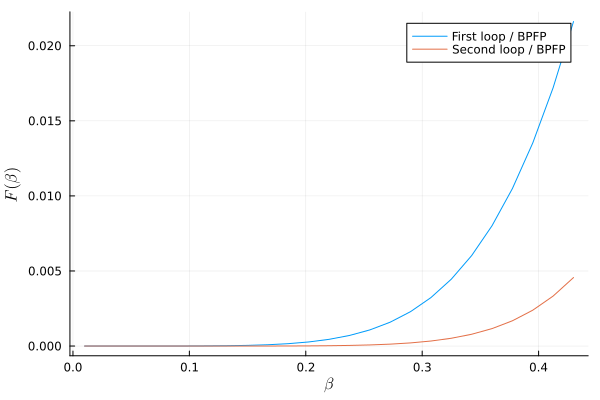

In [6]:
loop1_free_energy = [] 
loop2_free_energy = [] 
loop3_free_energy = []
βs = range(.01, .43 , length=25)
loop1 = [(1,2),(2,8),(7,8),(1,7)]
loop2 = [(1,2),(2,3),(3,9),(8,9),(7,8),(1,7)]
for β in βs
    tensors = get_ising_tn(g,N,β;h=0.0)
    adj_mat, edges, links = get_adj_mat(tensors)
    messages = get_messages(tensors,edges,links)
    messages = message_passing(tensors,messages,edges,links,adj_mat)
    Z_mf = mean_free_partition_fn(Set(1:N),tensors,messages,edges,links,adj_mat)
    Z_1loop =  loop_contribution(loop1,messages,tensors,edges,links,adj_mat)
    Z_2loop =  loop_contribution(loop2,messages,tensors,edges,links,adj_mat)
    push!(loop1_free_energy,Z_1loop./Z_mf )
    push!(loop2_free_energy,Z_2loop./Z_mf )
end
plot(βs, loop1_free_energy, label="First loop / BPFP", xlabel=L"β", ylabel=L"F(β)", legend=:topright)
plot!(βs, loop2_free_energy, label="Second loop / BPFP", xlabel=L"β", ylabel=L"F(β)", legend=:topright)


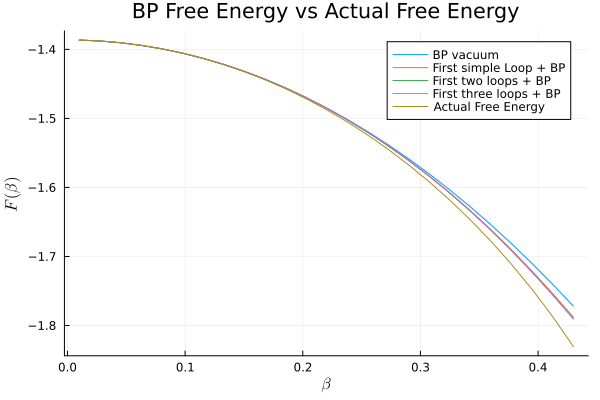

In [7]:
using HCubature

mf_free_energy = [] 
loop1_free_energy = [] 
loop2_free_energy = [] 
loop3_free_energy = []
actual_free_energy = []
loop1 = [(1,2),(2,8),(7,8),(1,7)]
loop2 = [(1,2),(2,3),(3,9),(8,9),(7,8),(1,7)]
loop3 = [(1,2),(2,3),(3,9),(8,9),(7,8),(1,7),(2,8)]
βs = range(.01, .43 , length=25)
for β in βs
    tensors = get_ising_tn(g,N,β;h=0.0)
    adj_mat, edges, links = get_adj_mat(tensors)
    messages = get_messages(tensors,edges,links)
    messages = message_passing(tensors,messages,edges,links,adj_mat)
    Z_mf = mean_free_partition_fn(Set(1:N),tensors,messages,edges,links,adj_mat)
    Z_1loop =  N * loop_contribution(loop1,messages,tensors,edges,links,adj_mat)
    Z_2loop =  N * loop_contribution(loop2,messages,tensors,edges,links,adj_mat)
    Z_3loop =  N * loop_contribution(loop3,messages,tensors,edges,links,adj_mat)
    push!(mf_free_energy,- log(Z_mf)/N)
    push!(loop1_free_energy,- log(Z_mf + Z_1loop)/N )
    push!(loop2_free_energy,- log(Z_mf + Z_1loop + Z_2loop)/N )
    push!(loop3_free_energy,- log(Z_mf + Z_1loop + Z_2loop + Z_3loop)/N)
    push!(actual_free_energy,free_energy(β) * 2)
end
plot(βs, mf_free_energy, label="BP vacuum", xlabel=L"β", ylabel=L"F(β)", title="BP Free Energy vs Actual Free Energy", legend=:topright)
plot!(βs, loop1_free_energy, label="First simple Loop + BP", xlabel=L"β", ylabel=L"F(β)", legend=:topright)
plot!(βs, loop2_free_energy, label="First two loops + BP", xlabel=L"β", ylabel=L"F(β)", legend=:topright)
plot!(βs, loop3_free_energy, label="First three loops + BP", xlabel=L"β", ylabel=L"F(β)", legend=:topright)
plot!(βs, actual_free_energy, label="Actual Free Energy", xlabel=L"β", ylabel=L"F(β)", legend=:topright)
# β_c=log(1+sqrt(2))/2
# vline!([β_c], linestyle=:dash, color=:red,label=L"\beta_c")

